<a href="https://colab.research.google.com/github/MattJCR/Algoritmo-KNN/blob/master/Algoritmo_KNN_Heart_Failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ALGORITMOS DE APRENDIZAJE SUPERVISADO: KNN - Heart Failure**
Clasificación binaria. El objetivo es clasificar entre presencia de enfermedad del corazón o no a partir de una serie de atributos (edad, sexo, colesterol, etc.). Para ello el dataset contiene una serie de datos pacientes etiquetados si tienen enfermedad o no.

In [ ]:
#@title Importación de librerías
import pandas as pd
import urllib.request
import tempfile
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statistics
import warnings
warnings.filterwarnings('ignore')
# Descargar clase Preprocessing para el tratado del dataset
urllib.request.urlretrieve('https://raw.githubusercontent.com/MattJCR/Algoritmo-KNN/master/Preprocessing.py', 'Preprocessing.py')
from Preprocessing import CleanData as cd

In [ ]:
#@title Obtención del dataset

# URL del archivo CSV en GitHub
url = 'https://raw.githubusercontent.com/MattJCR/Algoritmo-KNN/master/dataset/heart.csv'

# Descargar el archivo CSV
response = urllib.request.urlopen(url)

# Crear un archivo temporal para guardar el archivo CSV descargado
temp = tempfile.NamedTemporaryFile()

# Escribir los datos descargados en el archivo temporal
temp.write(response.read())

# Mover el puntero al inicio del archivo
temp.seek(0)

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(temp)

# Cerrar el archivo temporal
temp.close()

df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [ ]:
#@title Mostrado de primeras lineas del dataset
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
#@title Mostrado de ultimas lineas del dataset
df.tail(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


In [ ]:
#@title Obtener el resumen estadístico del DataFrame
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [ ]:
#@title Limpiado de datos y transformación de categóricos
df = cd.clean(df)
df = cd.transform_categorical_to_numeric(df)
df

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

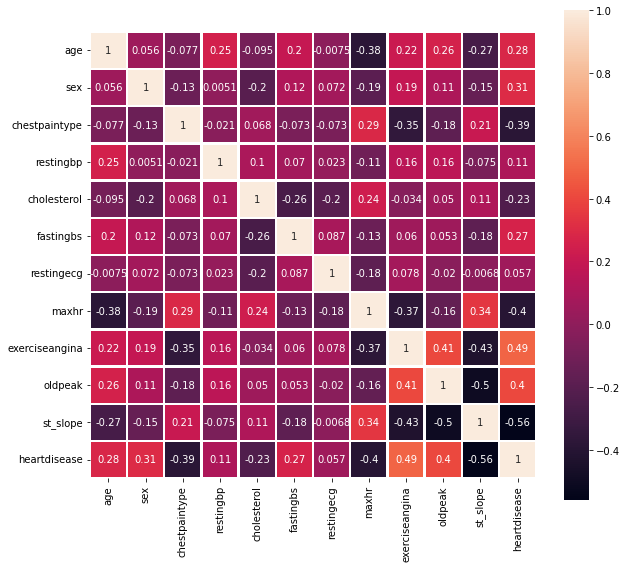

In [ ]:
#@title Mostrar un mapa de calor que indique la correlación entre variables

# Calcular la correlación entre las variables del DataFrame
corr = df.corr()

# Mostrar el mapa de calor de la correlación
plt.figure(figsize=(10, 9))
sns.heatmap(corr,square=True,annot=True,linewidths=1.5)
plt


## **Seleccionar las características a tener en cuenta en el estudio**
Para este estudio vamos a seleccionar las propiedades que tengan una relacion con heartdisease por encima de 0.25 y por debajo de -0.25 basandonos en el mapa de calor.

Por tanto vamos a eliminar las siguientes columnas:
* restingbp
* restingecg

In [ ]:
#@title Eliminación de columnas innecesarias y preprocesamiento de datos

# Borrado de columnas
df = df.drop('restingbp',axis=1)
df = df.drop('restingecg',axis=1)

df

,age,sex,chestpaintype,cholesterol,fastingbs,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,40,1,1,289,0,172,0,0.0,2,0
1,49,0,2,180,0,156,0,1.0,1,1
2,37,1,1,283,0,98,0,0.0,2,0
3,48,0,0,214,0,108,1,1.5,1,1
4,54,1,2,195,0,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,264,0,132,0,1.2,1,1
914,68,1,0,193,1,141,0,3.4,1,1
915,57,1,0,131,0,115,1,1.2,1,1
916,57,0,1,236,0,174,0,0.0,1,1


In [ ]:
#@title Separar datos entre datos de entrada y etiquetas (resultados)

# Obtenemos la columna heartdisease
df_heartdisease = df['heartdisease']

# Eliminamos la columna heartdisease del dataframe
df = df.drop('heartdisease',axis=1)

In [ ]:
#@title Separar datos entre entrenamiento y prueba (usando un 75% para entrenamiento y 25% para test)

x_train,x_test,y_train, y_test = train_test_split(df,df_heartdisease,random_state=1,train_size=0.75)

# **Entrenamiento y predicción**

In [ ]:
#@title Importamos el modelo KNN
modelo_KNN = KNeighborsClassifier(n_neighbors=3, weights="uniform")

In [ ]:
#@title Entrenamos el modelo KNN
modelo_KNN.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
#@title Realizar una predicción con los datos de prueba
predict = modelo_KNN.predict(x_test)
predict

array([1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0])

# **Evaluación**

In [ ]:
#@title Mostrar el porcentaje de elementos correctamente clasificados
accuracy_score(y_test, predict)

0.6826086956521739

In [ ]:
#@title Mostrar la predicción realizada (imprimir la variable con la predicción)
example = pd.DataFrame({'age':[18], 'sex':[0], 'chestpaintype':[0], 'cholesterol':[500], 'fastingbs':[0],
        'maxhr':[120], 'exerciseangina':[0], 'oldpeak':[.7], 'st_slope':[1]})
modelo_KNN.predict(example)[0]

1

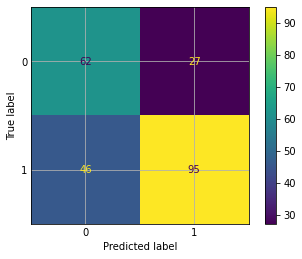

In [ ]:
#@title Representar gráficamente la clasificación obtenida (matriz de confusión)
ConfusionMatrixDisplay.from_predictions(y_test,predict)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

In [ ]:
#@title Mostrar el error cuadrático medio (mean_squared_error)
mean_squared_error(y_test, predict)

0.3173913043478261

In [ ]:
#@title Mostrar el error absoluto medio (mean_absolute_error)
mean_absolute_error(y_test, predict)

0.3173913043478261

# **Optimización de hiperparámetros**
Calcula la combinación de parámetros óptima (uniform o distance; valor de k). Para ello realiza ejecuciones con cada uno de los valores uniform y distance para los valores de k desde 1 a 30.

Cada ejecución anterior se deberá hacer usando validación cruzada (por ejemplo n_splits = 5). Con ello obtendremos una medida de bondad del modelo (accuracy_score o mean_absolute_error)), como lo ejecutaremos 5 veces, calcularemos la media de esas 5 ejecuciones.

In [ ]:
optimization_result = {'uniform':[],'distance':[]}
for k in range(1,30):
  modelo_KNN = KNeighborsClassifier(n_neighbors=k, weights="uniform")
  # Instanciar KFold con 5 divisiones y una semilla aleatoria fija
  kfold = KFold(n_splits=5)
  # Dividir los datos en conjuntos de entrenamiento y validación
  result = []
  for train_index, val_index in kfold.split(df):
    x_train, x_test = df.iloc[train_index], df.iloc[val_index]
    y_train, y_test = df_heartdisease.iloc[train_index], df_heartdisease.iloc[val_index]
        
    # Entrenar y evaluar el modelo con los conjuntos de entrenamiento y validación
    modelo_KNN.fit(x_train, y_train)
    predict = modelo_KNN.predict(x_test)
    score = accuracy_score(y_test, predict)
    #print(f'Score: {score:.2f}')
    result.append(score)
  optimization_result['uniform'].append(statistics.mean(result))
for k in range(1,30):
  modelo_KNN = KNeighborsClassifier(n_neighbors=k, weights="distance")
  # Instanciar KFold con 5 divisiones y una semilla aleatoria fija
  kfold = KFold(n_splits=5)
  # Dividir los datos en conjuntos de entrenamiento y validación
  result = []
  for train_index, val_index in kfold.split(df):
    x_train, x_test = df.iloc[train_index], df.iloc[val_index]
    y_train, y_test = df_heartdisease.iloc[train_index], df_heartdisease.iloc[val_index]
        
    # Entrenar y evaluar el modelo con los conjuntos de entrenamiento y validación
    modelo_KNN.fit(x_train, y_train)
    predict = modelo_KNN.predict(x_test)
    score = accuracy_score(y_test, predict)
    #print(f'Score: {score:.2f}')
    result.append(score)
  optimization_result['distance'].append(statistics.mean(result))

In [ ]:
#@title Finalmente los parámetros elegidos serán los que den mejor media de esas medidas anteriormente nombradas.

# Obtener el índice del elemento mayor
uniform_max_index = max(enumerate(optimization_result['uniform']), key=lambda x: x[1])[0]
distance_max_index = max(enumerate(optimization_result['distance']), key=lambda x: x[1])[0]
print('uniform[' + str(uniform_max_index) + ']:',optimization_result['uniform'][uniform_max_index],', n_neighbors=' + str(uniform_max_index + 1))
print('distance[' + str(distance_max_index) + ']:',optimization_result['distance'][distance_max_index],', n_neighbors=' + str(distance_max_index + 1))

uniform[26]: 0.7134295557139463 , n_neighbors=27
distance[26]: 0.7232418626752197 , n_neighbors=27


In [ ]:
#@title Una vez obtenidos esos parámetros óptimos los aplicaremos al problema en cuestión y mostraremos los resultados.

# Instanciamos el modelo con los parametros óptimos
modelo_KNN = KNeighborsClassifier(n_neighbors=27, weights="distance")

# Creamos los datos de entrenamiento
x_train,x_test,y_train, y_test = train_test_split(df,df_heartdisease,random_state=1,train_size=0.75)

# Entrenamos el modelo KNN
modelo_KNN.fit(x_train,y_train)

# Realizamos una predicción con los datos de prueba
predict = modelo_KNN.predict(x_test)

# Obtenemos el porcentaje de elementos correctamente clasificados
score = accuracy_score(y_test, predict)

# Obtenemos el error cuadrático medio
squared_error = mean_squared_error(y_test, predict)

# Obtenemos Mostrar el error absoluto medio (mean_absolute_error)
absolute_error = mean_absolute_error(y_test, predict)

print(f'accuracy_score: {score:.2f}')
print(f'mean_squared_error: {squared_error:.2f}')
print(f'mean_absolute_error: {absolute_error:.2f}')

accuracy_score: 0.72
mean_squared_error: 0.28
mean_absolute_error: 0.28


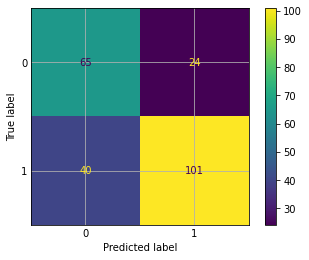

In [ ]:
# Representamos gráficamente la clasificación obtenida (matriz de confusión)

ConfusionMatrixDisplay.from_predictions(y_test,predict)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

# **Conclusiones**

En este estudio se ha llevado a cabo un análisis para clasificar si un paciente tiene o no enfermedad del corazón a partir de un conjunto de atributos (edad, sexo, colesterol, etc.). Se ha limpiado y transformado los datos utilizando la clase Preprocessing.py, se ha calculado la correlación entre las variables y se ha seleccionado aquellas características que tienen una relación con heartdisease del corazón superior a 0.25 o inferior a -0.25 basándose en el heatmap.

Luego, se han eliminado algunas columnas innecesarias (restingbp y restingecg) y se han separado los datos en un conjunto de entrenamiento y otro de prueba. 
Se ha entrenado el modelo KNN con el conjunto de entrenamiento y se han realizado predicciones con el conjunto de prueba, utilizando un 75% y un 25% respectivamente.

Se ha mostrado el porcentaje de elementos correctamente clasificados, se ha representado gráficamente la clasificación obtenida en una matriz de confusión y se han calculado el error cuadrático medio y el error absoluto medio.

Se ha realizado una optimización de los hiperparámetros del modelo KNN. Para ello, se han realizado ejecuciones con diferentes valores de "uniform" y "distance" para el peso de los vecinos más cercanos (k) y se han utilizado diferentes valores de k, desde 1 hasta 30. Cada ejecución se ha realizado mediante validación cruzada con cinco divisiones y se ha obtenido una medida de bondad del modelo (accuracy_score). Se ha calculado la media de las cinco ejecuciones para cada combinación de parámetros y se han elegido los parámetros que den la mejor media.

Una vez seleccionados los parámetros óptimos (n_neighbors=27, weights="distance"), se ha vuelto a entrenar el modelo KNN con el conjunto de entrenamiento y evaluar su rendimiento con el conjunto de prueba con una mejora del 0.68% al 0.72%.

